<a href="https://colab.research.google.com/github/dlai211/Emulsion-IFT-Matching/blob/main/Matching_v2_(Match).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Module

In [2]:
### For Colab Only
# !pip install uproot awkward lmfit
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [1]:
import uproot, scipy, math, os, random, time, pickle, collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import cdist
from lmfit.models import GaussianModel

# Emulsion Data Pre-processing

In [6]:
# emu = pd.read_csv("emulsion_data/chk_trks_F221_zone1_p200-210_test_50000_50000_pm11000.txt", sep='\s+', header=None)
# emu.columns = ["t->ID", "plate_first", "last_plate", "x1", "y1", "z1", "x", "y", "z", 
#                'tx1', 'ty1', "tx", "ty", "ty_pos", "tx_pos", "t->N()", "t->Npl()"]


#emu = pd.read_csv("emulsion_data/F221_zone3_pl198_210_sechi2_7.0/reco_comb.txt", sep='\s+', header=None)
emu = pd.read_csv("emulsion_data/F221_zone3_pl198_210_sechi2_7.0/reco43.txt", sep='\s+', header=None)

emu.columns = ["#_in_text_file", "#_in_subarea", "first_plate", "last_plate", 
                "x_first", "y_first", "z_first", "x_last", "y_last", "z_last", 
                "tx_first", "ty_first", "tx_last", "ty_last", "tx", "ty", "t->N()", "t->Npl()"]

# emu = emu[emu["last_plate"] > 208] # save last two layers
emu

,#_in_text_file,#_in_subarea,first_plate,last_plate,x_first,y_first,z_first,x_last,y_last,z_last,tx_first,ty_first,tx_last,ty_last,tx,ty,t->N(),t->Npl()
0,0,0,198,210,88215.015625,57554.765625,280239.78125,87881.570312,57557.843750,296900.0,-0.022459,-0.004303,-0.020227,-0.000231,-0.020016,0.000203,13,13
1,1,1,198,210,88261.984375,57876.750000,280239.78125,88018.867188,57871.914062,296900.0,-0.017775,0.004628,-0.014714,0.000279,-0.014651,-0.000172,13,13
2,2,2,198,210,87944.570312,57547.843750,280239.78125,87703.867188,57575.437500,296900.0,-0.015116,0.001754,-0.017313,0.002699,-0.014417,0.001677,13,13
3,3,3,198,210,88089.007812,57779.742188,280239.78125,87803.835938,57778.359375,296900.0,-0.018757,0.000780,-0.017941,-0.000344,-0.017114,-0.000086,13,13
4,4,4,198,210,88249.078125,57663.664062,280239.78125,88009.812500,57791.464844,296900.0,-0.015630,0.003037,-0.013195,0.008201,-0.014424,0.007718,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29950,29950,34504,198,210,96892.078125,64678.746094,280239.78125,96727.718750,64647.808594,296900.0,-0.007122,-0.001356,-0.011654,-0.000181,-0.009867,-0.001820,10,13
29951,29951,34505,198,210,102248.859375,65295.363281,280239.78125,102083.703125,65295.320312,296900.0,-0.010718,-0.001491,-0.010523,0.001959,-0.009956,0.000074,11,13
29952,29952,34506,198,210,90906.585938,66628.695312,281619.68750,90753.085938,66660.242188,296900.0,-0.012696,0.003985,-0.012434,0.004216,-0.010065,0.002084,10,12
29953,29953,34507,198,210,97477.648438,67680.734375,280239.78125,97976.812500,66008.976562,296900.0,0.037064,-0.104355,0.016470,-0.105755,0.028270,-0.099299,11,13


In [7]:
##plot last_plate
# plt.hist(emu['last_plate'], bins=100)
# plt.show()

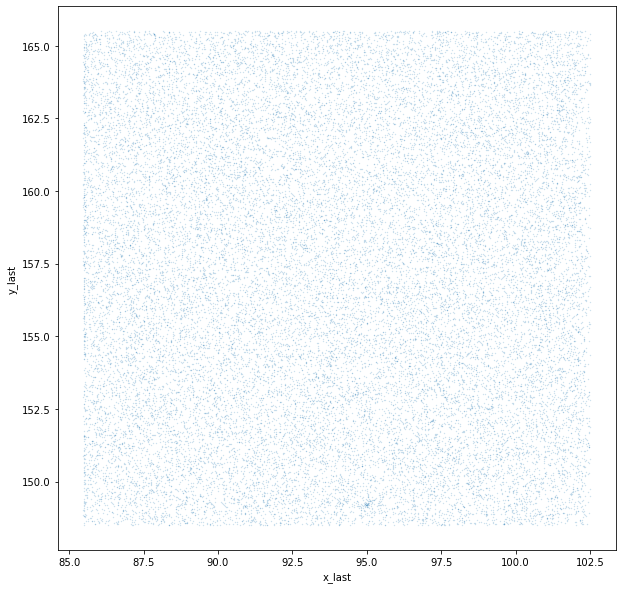

In [8]:
# plot last_x vs. last_y
plt.figure(figsize=(10, 10))
plt.scatter(emu['x_last']/1e3 -1 , emu['y_last']/1e3 + 92, s=0.1, alpha=0.3)
plt.xlabel('x_last')
plt.ylabel('y_last')
plt.show()


In [9]:
# selcet x y range for last plate
# emu = emu[(emu['x_last']/1e3 > 85) & (emu['y_last']/1e3 > 85)]

In [10]:
emu = pd.DataFrame({
    # convert to x, y to mm and right position with respect to nominal LoS
    # the center of the emulsion (125, 150)mm is around the nominal LoS
    'x': emu.x_last/1e3 - 1 , # emulsion is +10 mm to nominal LoS in x
    'y': emu.y_last/1e3 + 92, # emulsion is -33 mm to nominal LoS in y
    'z': emu.z_last/1e3,
    'tx': emu.tx,
    'ty': emu.ty
})
emu

,x,y,z,tx,ty
0,86.881570,149.557844,296.9,-0.020016,0.000203
1,87.018867,149.871914,296.9,-0.014651,-0.000172
2,86.703867,149.575437,296.9,-0.014417,0.001677
3,86.803836,149.778359,296.9,-0.017114,-0.000086
4,87.009812,149.791465,296.9,-0.014424,0.007718
...,...,...,...,...,...
29950,95.727719,156.647809,296.9,-0.009867,-0.001820
29951,101.083703,157.295320,296.9,-0.009956,0.000074
29952,89.753086,158.660242,296.9,-0.010065,0.002084
29953,96.976812,158.008977,296.9,0.028270,-0.099299


In [16]:
#first find area in x-y plane
x_min = min(emu['x'])
x_max = max(emu['x'])
y_min = min(emu['y'])
y_max = max(emu['y'])
print(x_min, x_max, y_min, y_max)

area = (x_max - x_min) * (y_max - y_min)

#find density
density = len(emu['x'])/area

print("Track density: {:.3f} tracks/mm²".format(density))

85.471265625 102.514125 148.496871094 165.503953125
Track density: 103.347 tracks/mm²


# Tracking Station Pre-processing

In [115]:
# f_data = uproot.open('/content/drive/MyDrive/data/ForAli/match2.root')
f_data = uproot.open('/Users/aligarabaglu/Downloads/match3.root')

data = f_data['trackParam'].arrays(['run',
                                    'eventTime',
                                    'fitParam_x',
                                    'fitParam_y',  
                                    'fitParam_z',
                                    'fitParam_px',
                                    'fitParam_py',
                                    'fitParam_pz',
                                    'fitParam_chi2',
                                    'fitParam_charge',
                                    'fitParam_nMeasurements',
                                    'fitParam_align_id',
                                    'fitParam_align_local_residual_x'],library='ak') 

In [117]:
# Count the occurence of each element
timestamp = data['eventTime']
track_count = collections.Counter(timestamp)

num_evt = []
for i in tqdm(timestamp):
    num_evt.append(track_count[i])

ift1 = data[np.array(num_evt) >= 18]

100%|██████████| 1978492/1978492 [00:05<00:00, 351129.08it/s]


## Event/Track Selection (IFT Only)

In [126]:
# All event has one and only one track
# do NOT need ak.num to select number of track
cut = ak.where((ak.flatten(ift1['fitParam_z']) < -1880)&  # can use flatten, instead of firsts
               (ak.flatten(ift1['fitParam_chi2']) < 100)&
               (ak.flatten(ift1['fitParam_pz']) < 200*1e3))

In [127]:
ift = ift1[cut]

ift['fitParam_x'] = ift['fitParam_x'] + 115
ift['fitParam_y'] = ift['fitParam_y'] + 171

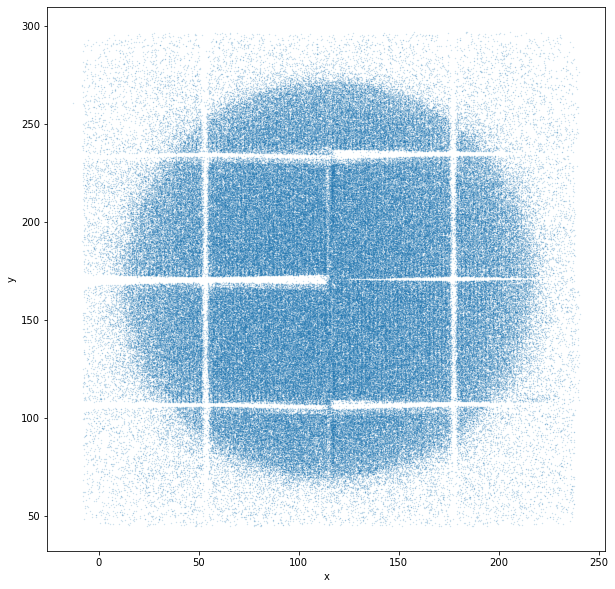

In [128]:
#plot ift x vs. y
plt.figure(figsize=(10, 10))
plt.scatter(ak.flatten(ift['fitParam_x']), ak.flatten(ift['fitParam_y']), s=0.1, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-121, 121)
# plt.ylim(-121, 121)
plt.show()

In [89]:

# plt.figure(figsize=(12, 12))
# plt.scatter(ift['fitParam_x']+125, ift['fitParam_y']+138,  marker='.', color='orange', s=1, alpha=0.5, label='IFT Data')
# plt.scatter(emu['x'], emu['y'], marker='.', color='green', s=1, label='Emulsion Data')
# plt.xlim(-70, 275)
# plt.ylim(-70, 275)

# from matplotlib.patches import Rectangle, Circle

# # plot points
# plt.scatter(125, 150, c='purple', s=100, label='Nominal LoS')
# plt.scatter(125, 138, c='black', s=100, label='Center of IFT/Magnet')
# plt.scatter(135, 117, c='steelblue', s=100, label='Center of Emulsion')

# # plot rectangle
# rect = Rectangle((135 - 125, 117 - 150), 250, 300, edgecolor='steelblue', facecolor='none', label='Emulsion')
# plt.gca().add_patch(rect)

# # plot circle
# circle = Circle((125, 138), 100, edgecolor='black', facecolor='none', label='Magnet Apperture')
# plt.gca().add_patch(circle)

# # set axis limits and aspect ratio
# plt.xlabel('x (mm)')
# plt.ylabel('y (mm)')

# # show plot
# plt.legend()
# plt.show()

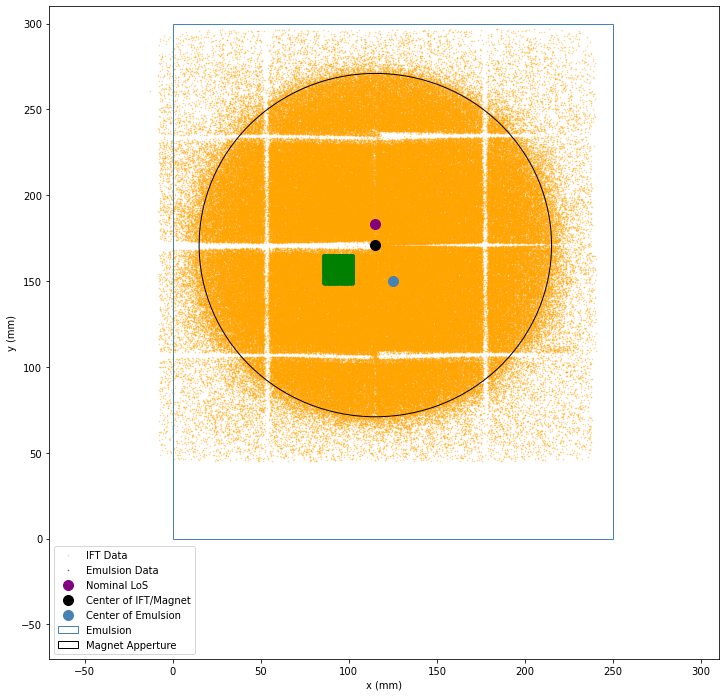

In [129]:
plt.figure(figsize=(12, 12))
# plt.scatter(ift['fitParam_x']+125, ift['fitParam_y']+138,  marker='.', color='orange', s=1, alpha=0.5, label='IFT Data')
plt.scatter(ift['fitParam_x'], ift['fitParam_y'],  marker='.', color='orange', s=1, alpha=0.5, label='IFT Data')
plt.scatter(emu['x'], emu['y'], marker='.', color='green', s=1, label='Emulsion Data')


plt.xlim(-70, 310)
plt.ylim(-70, 310)

from matplotlib.patches import Rectangle, Circle

# plot points
plt.scatter(115, 183, c='purple', s=100, label='Nominal LoS')
plt.scatter(115, 171, c='black', s=100, label='Center of IFT/Magnet')
plt.scatter(125, 150, c='steelblue', s=100, label='Center of Emulsion')

# plot rectangle
rect = Rectangle((0, 0), 250, 300, edgecolor='steelblue', facecolor='none', label='Emulsion')
plt.gca().add_patch(rect)

# plot circle
circle = Circle((115, 171), 100, edgecolor='black', facecolor='none', label='Magnet Apperture')
plt.gca().add_patch(circle)

# set axis limits and aspect ratio
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# show plot
plt.legend()
plt.show()

In [130]:
ift_x_matching = ift['fitParam_x'][(ift['fitParam_x'] > 86) & (ift['fitParam_x'] < 103)]

ift_y_matching = ift['fitParam_y'][(ift['fitParam_y'] > 149) & (ift['fitParam_y'] < 166)]

ift_x_min = min(ak.flatten(ift_x_matching))
ift_x_max = max(ak.flatten(ift_x_matching))
ift_y_min = min(ak.flatten(ift_y_matching))
ift_y_max = max(ak.flatten(ift_y_matching))

# ift_x_min = min(ak.flatten(ift['fitParam_x']))
# ift_x_max = max(ak.flatten(ift['fitParam_x']))
# ift_y_min = min(ak.flatten(ift['fitParam_y']))
# ift_y_max = max(ak.flatten(ift['fitParam_y']))

print(ift_x_min, ift_x_max, ift_y_min, ift_y_max)

ift_area = (ift_x_max - ift_x_min) * (ift_y_max - ift_y_min)

#find density
ift_density = len(ak.flatten(ift_x_matching))/ift_area

print("Track density: {:.3f} tracks/mm²".format(ift_density))

86.0003433227539 102.99918937683105 149.00035858154297 165.99955224990845
Track density: 129.890 tracks/mm²


# Tx & Ty

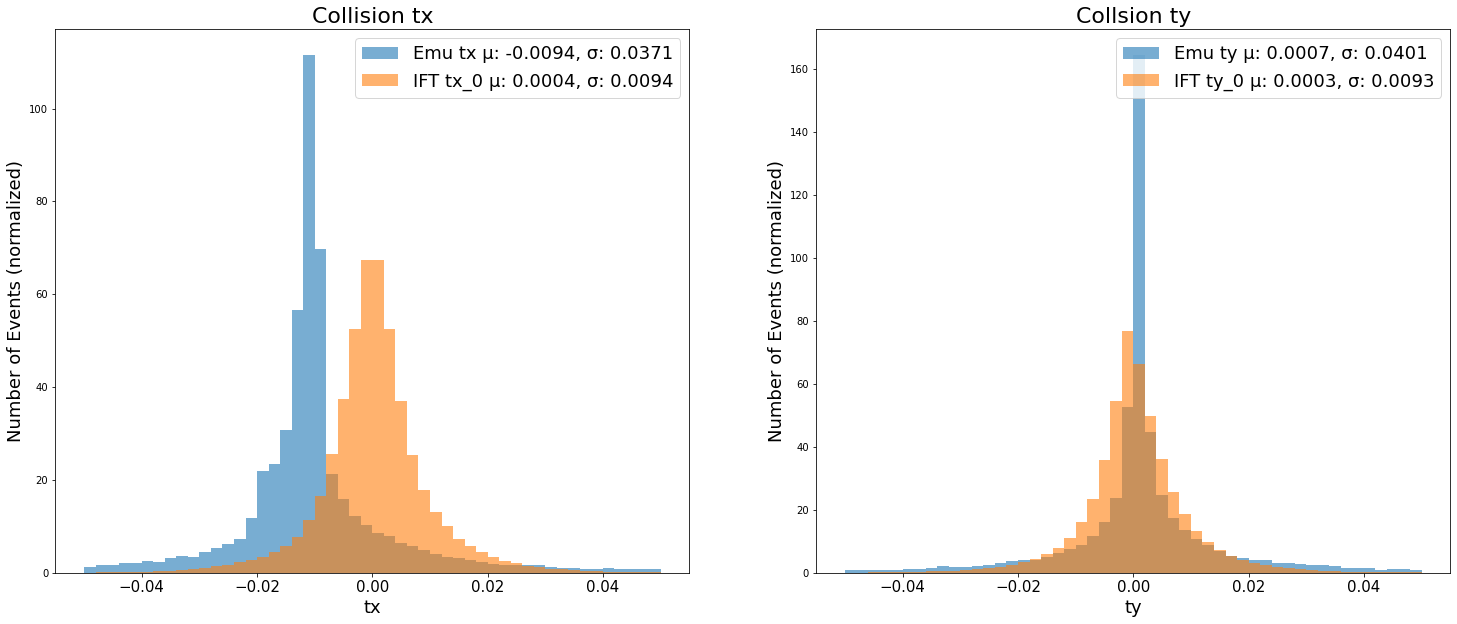

In [131]:
# tx
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(-0.05, 0.05, 51)
round_num = 4
emutx_mean, emutx_std = round(np.mean(emu['tx']), round_num), round(np.std(emu['tx']), round_num)
plt.hist(emu['tx'], bins=bin, alpha=.6, density=True, label=f'Emu tx µ: {emutx_mean}, σ: {emutx_std}')

ift_tx, ift_ty = ak.flatten(ift['fitParam_px']/ift['fitParam_pz']), ak.flatten(ift['fitParam_py']/ift['fitParam_pz'])
ifttx_mean, ifttx_std = round(np.mean(ift_tx), round_num), round(np.std(ift_tx), round_num)
plt.hist(ift_tx, bins=bin, alpha=.6, density=True, label=f'IFT tx_0 µ: {ifttx_mean}, σ: {ifttx_std}')

#emurot_mean, emurot_std = round(np.mean(emu_rot['tx']), round_num), round(np.std(emu_rot['tx']), round_num)
#plt.hist(emu_rot['tx'], bins=bin, alpha=0.round_num, density=True, label=f'Emu (rotated) tx µ: {round(emurot_mean, 5)}, σ: {emurot_std}')

plt.xlabel('tx', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.title('Collision tx', fontsize=22)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)

# ty
plt.subplot(1, 2, 2)
emuty_mean, emuty_std = round(np.mean(emu['ty']), round_num), round(np.std(emu['ty']), round_num)
plt.hist(emu['ty'], bins=bin, alpha=.6, density=True, label=f'Emu ty µ: {emuty_mean}, σ: {emuty_std}')

iftty_mean, iftty_std = round(np.mean(ift_ty), round_num), round(np.std(ift_ty), round_num)
plt.hist(ift_ty, bins=bin, alpha=.6, density=True, label=f'IFT ty_0 µ: {iftty_mean}, σ: {iftty_std}')

#emurot_mean, emurot_std = round(np.mean(emu_rot['ty']), round_num), round(np.std(emu_rot['ty']), round_num)
#plt.hist(emu_rot['ty'], bins=bin, alpha=0.round_num, density=True, label=f'Emu (rotated) ty µ: {round(emurot_mean, 5)}, σ: {emurot_std}')

plt.xlabel('ty', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.title('Collsion ty', fontsize=22)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()

# Initial angle alignment for emulsion to match IFT 

In [132]:
def track_angles(tx, ty):
    theta = np.ones(len(tx))
    phi = np.ones(len(tx))
    for i, (x, y) in enumerate(zip(tx, ty)):
        # calculate phi
        if x > 0:
            phi[i] = np.arctan(y/x)
        elif x < 0 and y >= 0:
            phi[i] = np.arctan(y/x) + np.pi
        elif x < 0 and y < 0:
            phi[i] = np.arctan(y/x) - np.pi
        elif x == 0 and y > 0:
            phi[i] = np.pi/2
        elif x == 0 and y < 0:
            phi[i] = -np.pi/2
        elif x == 0 and y == 0:
            print(f'At Event {i}, there occurs both tx & ty values are zero (tx:{tx[i]}, ty:{ty[i]})')
            phi[i] = np.nan

        # calculate theta
        theta[i] = np.arctan(np.sqrt(x**2 + y**2))

    return theta, phi



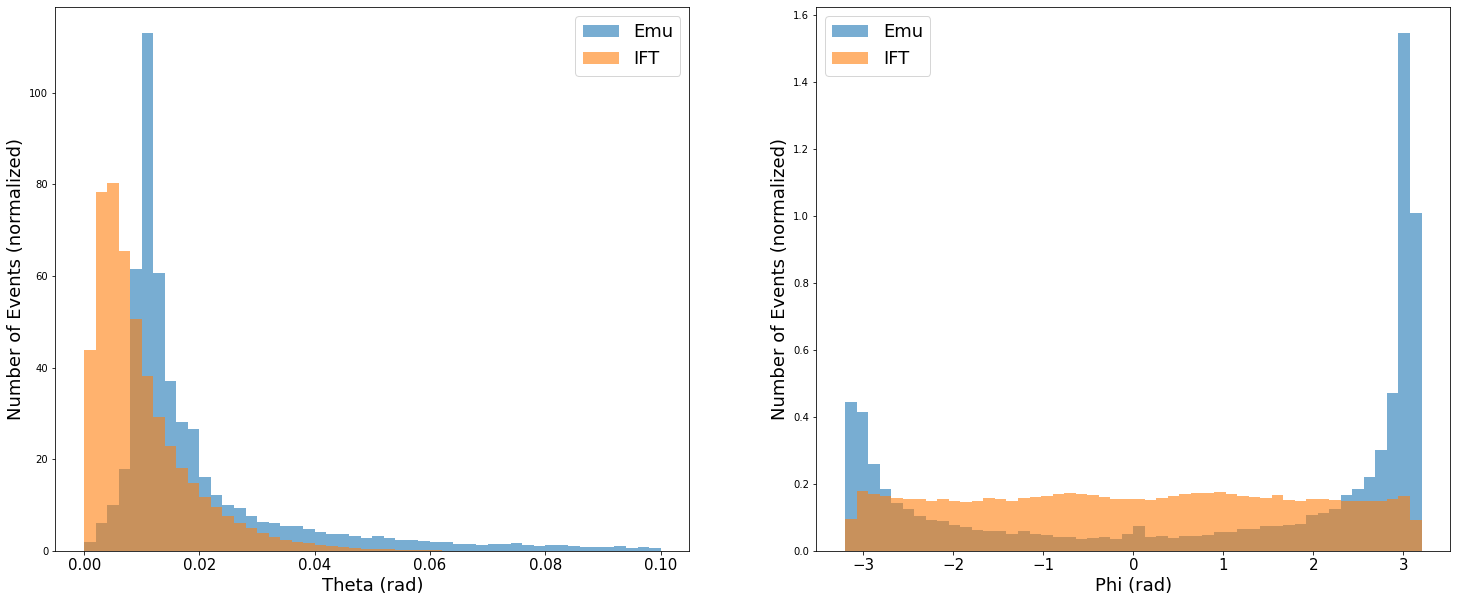

In [133]:
# using track_angles plot theta and phi 
emu_theta, emu_phi = track_angles(emu['tx'], emu['ty'])
ift_theta, ift_phi = track_angles(ift_tx, ift_ty)

# tx
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(0, 0.1, 51)
plt.hist(emu_theta, bins=bin, alpha=.6, density=True, label=f'Emu')
plt.hist(ift_theta, bins=bin, alpha=.6, density=True, label=f'IFT')
plt.xlabel('Theta (rad)', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)

# ty
plt.subplot(1, 2, 2)
bin = np.linspace(-3.2, 3.2, 51)
plt.hist(emu_phi, bins=bin, alpha=.6, density=True, label=f'Emu')
plt.hist(ift_phi, bins=bin, alpha=.6, density=True, label=f'IFT')
plt.xlabel('Phi (rad)', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()

In [134]:
emu_tx_mean = np.mean(emu['tx'])
emu_ty_mean = np.mean(emu['ty'])
ift_tx_mean = np.mean(ift_tx)
ift_ty_mean = np.mean(ift_ty)

print(emu_tx_mean, emu_ty_mean, ift_tx_mean, ift_ty_mean)

# theta_emu, phi_emu = track_angles(emu['tx'], emu['ty'])
# theta_ift, phi_ift = track_angles(ift_tx, ift_ty)

theta_emu, phi_emu = np.arctan(np.sqrt(emu_tx_mean**2 + emu_ty_mean**2)), np.arctan(emu_ty_mean/emu_tx_mean)+np.pi
theta_ift, phi_ift = np.arctan(np.sqrt(ift_tx_mean**2 + ift_ty_mean**2)), np.arctan(ift_ty_mean/ift_tx_mean)

ift_x = np.sin(theta_ift)*np.cos(phi_ift)
ift_y = np.sin(theta_ift)*np.sin(phi_ift)
ift_z = np.cos(theta_ift)

emu_x = np.sin(theta_emu)*np.cos(phi_emu)
emu_y = np.sin(theta_emu)*np.sin(phi_emu)
emu_z = np.cos(theta_emu)

emu_vector = np.array([emu_x, emu_y, emu_z])
ift_vector = np.array([ift_x, ift_y, ift_z])
# print(emu_vector)
# print(np.mean(emu['x']))

# dot prodict between two vectors 
dot = ift_x*emu_x + ift_y*emu_y + ift_z*emu_z
# normalize the dot vector
norm_dot = np.dot(emu_vector, ift_vector)/(np.sqrt(ift_x**2 + ift_y**2 + ift_z**2) * np.sqrt(emu_x**2 + emu_y**2 + emu_z**2))
# find angles between two normal vectors
angle = np.arccos(norm_dot)
print(angle)

# Step 3: Calculate the axis of rotation
axis = np.cross(emu_vector, ift_vector)
axis /= np.linalg.norm(axis)

# Step 5: Construct the rotation matrix
# rotated_emu = emu_vector * np.cos(angle) + np.cross(axis, emu_vector) * np.sin(angle) + axis * np.dot(axis, emu_vector) * (1 - np.cos(angle))

# tx_emulsion_aligned = rotated_emu[0] / rotated_emu[2]
# ty_emulsion_aligned = rotated_emu[1] / rotated_emu[2]
# print(tx_emulsion_aligned, ty_emulsion_aligned)


-0.009414041595726924 0.0007122980136871974 0.0003636469454749114 0.0003400351745286517
0.009784491981055576


In [135]:
theta_emu, phi_emu = track_angles(emu['tx'], emu['ty'])
emu_x = np.sin(theta_emu)*np.cos(phi_emu)
emu_y = np.sin(theta_emu)*np.sin(phi_emu)
emu_z = np.cos(theta_emu)
# print(emu_x, emu_y, emu_z)
emu_vector = np.vstack((emu_x, emu_y, emu_z)).T
# print(emu_vector)
# print(emu_vector.shape)
# print(axis)
tiled_axis = np.tile(axis, (emu_vector.shape[0], 1))
dot_product = np.sum(tiled_axis * emu_vector, axis=1)
dot_product = dot_product.reshape((dot_product.shape[0], 1))
rotated_emu = (emu_vector * np.cos(angle) 
               + np.cross(tiled_axis, emu_vector) * np.sin(angle) 
               + tiled_axis * dot_product * (1 - np.cos(angle)))


# print(rotated_emu)
tx_emulsion_aligned = rotated_emu[:, 0] / rotated_emu[:, 2]
ty_emulsion_aligned = rotated_emu[:, 1] / rotated_emu[:, 2]

In [136]:
rot_emu = pd.DataFrame({
    'x': (tx_emulsion_aligned*emu['z']) + (emu['x'] - emu['tx']*emu['z']),
    'y': (ty_emulsion_aligned*emu['z']) + (emu['y'] - emu['ty']*emu['z']),
    'z':  emu['z'],
    'tx': tx_emulsion_aligned,
    'ty': ty_emulsion_aligned
})

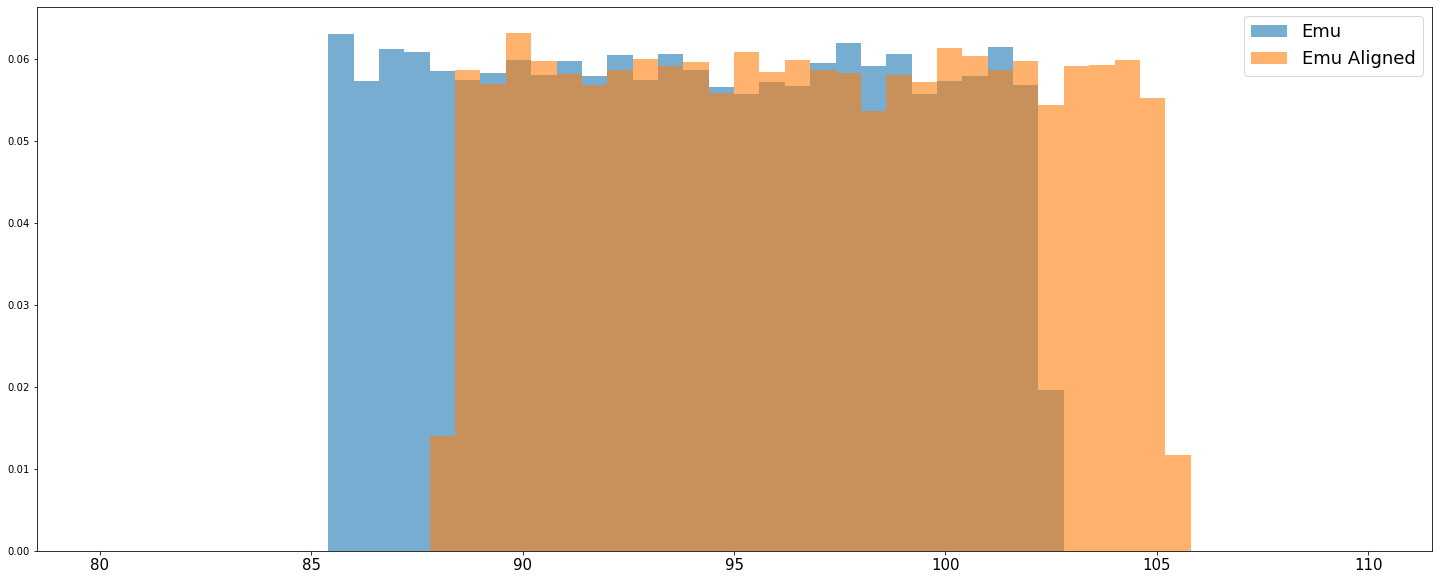

In [137]:
# plot emu['x'] and rotated_emu[:, 0] each as hist on smae plot
plt.figure(figsize=(25, 10))
bin = np.linspace(80, 110, 51)
plt.hist(emu['x'], bins=bin, alpha=.6, density=True, label=f'Emu')
plt.hist((tx_emulsion_aligned*emu['z']) + (emu['x'] - emu['tx']*emu['z']), bins=bin, alpha=.6, density=True, label=f'Emu Aligned')
plt.xticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()


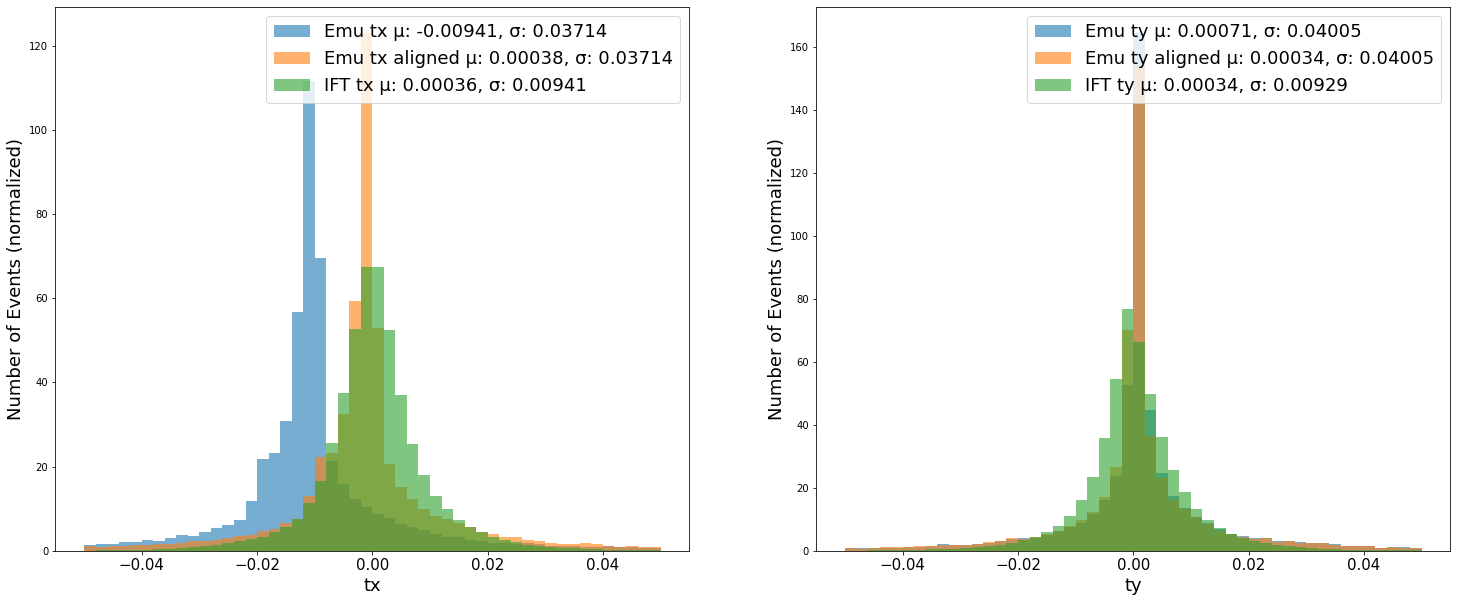

In [138]:
# plot tx and ty of emulsion before and after alignment
plt.figure(figsize=(25, 10))
round_num = 5
plt.subplot(1, 2, 1)
bin = np.linspace(-0.05, 0.05, 51)
emutx_mean, emutx_std = round(np.mean(emu['tx']), round_num), round(np.std(emu['tx']), round_num)
plt.hist(emu['tx'], bins=bin, alpha=.6, density=True, label=f'Emu tx µ: {emutx_mean}, σ: {emutx_std}')
#new emulsion tx
emutx_aligned_mean, emutx_aligned_std = round(np.mean(tx_emulsion_aligned), round_num), round(np.std(tx_emulsion_aligned), round_num)
plt.hist(tx_emulsion_aligned, bins=bin, alpha=.6, density=True, label=f'Emu tx aligned µ: {emutx_aligned_mean}, σ: {emutx_aligned_std}')
#plot ift tx 
ifttx_mean, ifttx_std = round(np.mean(ift_tx), round_num), round(np.std(ift_tx), round_num)
plt.hist(ift_tx, bins=bin, alpha=.6, density=True, label=f'IFT tx µ: {ifttx_mean}, σ: {ifttx_std}')

plt.xlabel('tx', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)

plt.subplot(1, 2, 2)
bin = np.linspace(-0.05, 0.05, 51)
emuty_mean, emuty_std = round(np.mean(emu['ty']), round_num), round(np.std(emu['ty']), round_num)
plt.hist(emu['ty'], bins=bin, alpha=.6, density=True, label=f'Emu ty µ: {emuty_mean}, σ: {emuty_std}')
#new emulsion ty
emuty_aligned_mean, emuty_aligned_std = round(np.mean(ty_emulsion_aligned), round_num), round(np.std(ty_emulsion_aligned), round_num)
plt.hist(ty_emulsion_aligned, bins=bin, alpha=.6, density=True, label=f'Emu ty aligned µ: {emuty_aligned_mean}, σ: {emuty_aligned_std}')
#plot ift ty
iftty_mean, iftty_std = round(np.mean(ift_ty), round_num), round(np.std(ift_ty), round_num)
plt.hist(ift_ty, bins=bin, alpha=.6, density=True, label=f'IFT ty µ: {iftty_mean}, σ: {iftty_std}')

plt.xlabel('ty', fontsize=18)
plt.ylabel('Number of Events (normalized)', fontsize=18)
plt.xticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()




# Extrapoluation (Emulsion -> IFT)
 - ## no magnetic field (straight line prediction)

In [139]:
# distance from IFT to emulsion in MC [mm]
# DistEmuIft = 55.5

# distance from IFT to emulsion in collsion data [mm]
DistEmuIft = 63.4

# Z position of module 0 and 2, which is smallest z position in IFT 1st layer
module0_z = -1898.0509 # mm

# Z position of module 4 and 6, which is largest z position in IFT 1st layer
module4_z = -1886.1353 # mm


'''
# IFT to Emulsion Extrapolation
iftFront_z = -1898.05 # frontest IFT z position

def ift2emu(x, y, z, px, py, pz):
    tx = px/pz
    ty = py/pz

    # Extrapolation
    Dist_tot = DistEmuIft + (z - iftFront_z)
    x_pred = Dist_tot * (-tx) + x
    y_pred = Dist_tot * (-ty) + y
    return x_pred, y_pred

ift_x_pred, ift_y_pred = ift2emu(x_tran, y_tran, ak.flatten(ift['fitParam_z']), ak.flatten(ift['fitParam_px']), ak.flatten(ift['fitParam_py']), ak.flatten(ift['fitParam_pz']))
'''

# Emulsion to IFT Extrapolation
# Step 1: Emulsion to IFT module 4
def emu2ift(x, y, tx, ty):
    Dist_tot = DistEmuIft + np.abs(module0_z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

emu_x_pred, emu_y_pred = emu2ift(rot_emu['x'], rot_emu['y'], rot_emu['tx'], rot_emu['ty'])

def ift2ift(x, y, z, tx, ty):
    Dist_tot = np.abs(z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

ift_x_pred, ift_y_pred = ift2ift(ak.flatten(ift['fitParam_x']), ak.flatten(ift['fitParam_y']), ak.flatten(ift['fitParam_z']), ift_tx, ift_ty)

In [140]:
# Organize the data
IFT = pd.DataFrame({
    'x': ift_x_pred,
    'y': ift_y_pred,
    'tx': ift_tx, 
    'ty': ift_ty
})

Emu = pd.DataFrame({
    'x': emu_x_pred,
    'y': emu_y_pred,
    'tx': rot_emu['tx'],
    'ty': rot_emu['ty']
})

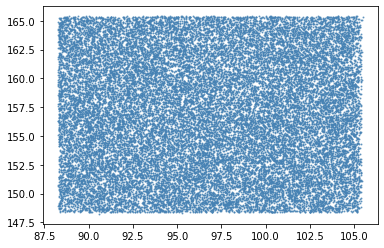

In [141]:
plt.scatter(rot_emu['x'], rot_emu['y'], marker='.', color='steelblue', s=4, alpha=0.7,  label='Emulsion Data')

# Preparing Matching Data

In [142]:
# ty cut
ty_low_ift, ty_up_ift = -0.1, 0.1
ty_low_emu, ty_up_emu = -0.1, 0.1

emu_filter = Emu[(Emu['ty'] > ty_low_emu) & (Emu['ty'] < ty_up_emu)]
ift_filter = IFT[(IFT['ty'] > ty_low_ift) & (IFT['ty'] < ty_up_ift) &\
                   (IFT['y'] > 150) & (IFT['y'] < 162) &\
                   (IFT['x'] > 90) & (IFT['x'] < 102)]


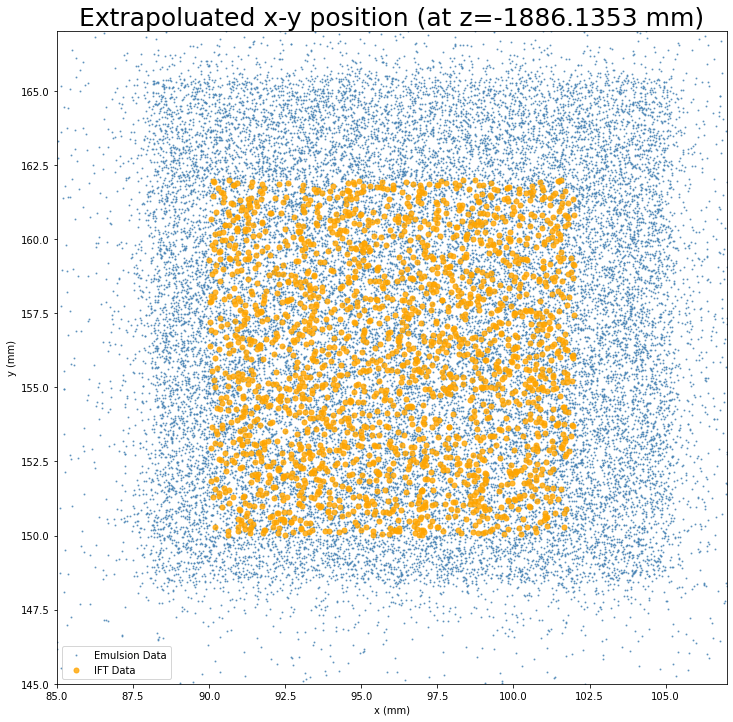

In [143]:
# Checking
plt.figure(figsize=(12, 12))
plt.scatter(emu_filter['x'], emu_filter['y'], marker='.', color='steelblue', s=4, alpha=0.7,  label='Emulsion Data')
plt.scatter(ift_filter['x'], ift_filter['y'],  marker='.', color='orange', s=100, alpha=0.8, label='IFT Data')
plt.xlim(85, 107)
plt.ylim(145, 167)
# set axis limits and aspect ratio
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Extrapoluated x-y position (at z=-1886.1353 mm)', fontsize=25)

# show plot
plt.legend()
plt.show()

# Chi2 Algorithm

In [159]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295 # obtain these from truth match residual

Chi2 = []
resx, resy, restx, resty = [], [], [], []
for i in range(len(ift_filter.x)):
    emu_filter2 = emu_filter[(emu_filter.x > ift_filter.x.iloc[i]-3*x_res/2) & (emu_filter.x < ift_filter.x.iloc[i]+3*x_res/2) & (emu_filter.y > ift_filter.y.iloc[i]-3*y_res/2) & (emu_filter.y < ift_filter.y.iloc[i]+3*y_res/2)]
    chi2 = np.sqrt((ift_filter.x.iloc[i]-emu_filter2.x)**2/(1.7211)**2 + (ift_filter.y.iloc[i]-emu_filter2.y)**2/(0.01811)**2 + (ift_filter.tx.iloc[i]-emu_filter2.tx)**2/(0.01406)**2 + (ift_filter.ty.iloc[i]-emu_filter2.ty)**2/(0.00295)**2)
    if np.min(chi2) < 20: 
        min_num = np.where(chi2==np.min(chi2))[0][0]
        resx.append(ift_filter.x.iloc[i] - emu_filter2.x.iloc[min_num])
        resy.append(ift_filter.y.iloc[i] - emu_filter2.y.iloc[min_num])
        restx.append(ift_filter.tx.iloc[i] - emu_filter2.tx.iloc[min_num])
        resty.append(ift_filter.ty.iloc[i] - emu_filter2.ty.iloc[min_num])

In [164]:
emu_stack = np.stack(((emu_filter.x)/(1.7211), (emu_filter.y)/(0.01811), emu_filter.tx/(0.01406), emu_filter.ty/(0.00295)), axis=1)
ift_stack = np.stack(((ift_filter.x)/(1.7211), (ift_filter.y)/(0.01811), ift_filter.tx/(0.01406), ift_filter.ty/(0.00295)), axis=1)

t0 = time.time()
cdist_tot = cdist(ift_stack, emu_stack) # all ift point and all emu point
cdist_min = cdist(ift_stack, emu_stack).min(axis=-1)  # for each ift point, minimum chi2 for matching emu points
cdist_minpos = cdist(ift_stack, emu_stack).argmin(axis=-1)  # finding the position of emu with minimum chi2
pos_maxchi2 = ak.where(cdist_min < 20)[0]  # maximum chi2 = 20
cdist_minpos = cdist_minpos[pos_maxchi2]  # selecting mini position (above) with maximum chi2

resx = np.array(ift_filter.x)[pos_maxchi2] - np.array(emu_filter.x)[cdist_minpos]
resy = np.array(ift_filter.y)[pos_maxchi2] - np.array(emu_filter.y)[cdist_minpos]
restx = np.array(ift_filter.tx)[pos_maxchi2] - np.array(emu_filter.tx)[cdist_minpos]
resty = np.array(ift_filter.ty)[pos_maxchi2] - np.array(emu_filter.ty)[cdist_minpos]
print('time:', time.time()-t0, 's')

time: 2.6399080753326416 s


In [165]:
def gauss_fit(data, min, max):
    data = np.array(data)
    data = data[(data > min) & (data < max)]
    npix = len(data)
    nbins = int(npix)
    n, bins = np.histogram(data, bins=nbins, density=True)
    n, bins = np.array(n), np.array(bins)
    # Generate data from bins as a set of points 
    bin_size = abs(bins[1]-bins[0])
    x =np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0, num=nbins,endpoint=True)
    y = n
    model = GaussianModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    mean = result.params['center'].value
    mean_err = result.params['center'].stderr
    stddev = result.params['sigma'].value
    stddev_err = result.params['sigma'].stderr
    return result, x, mean, mean_err, stddev, stddev_err


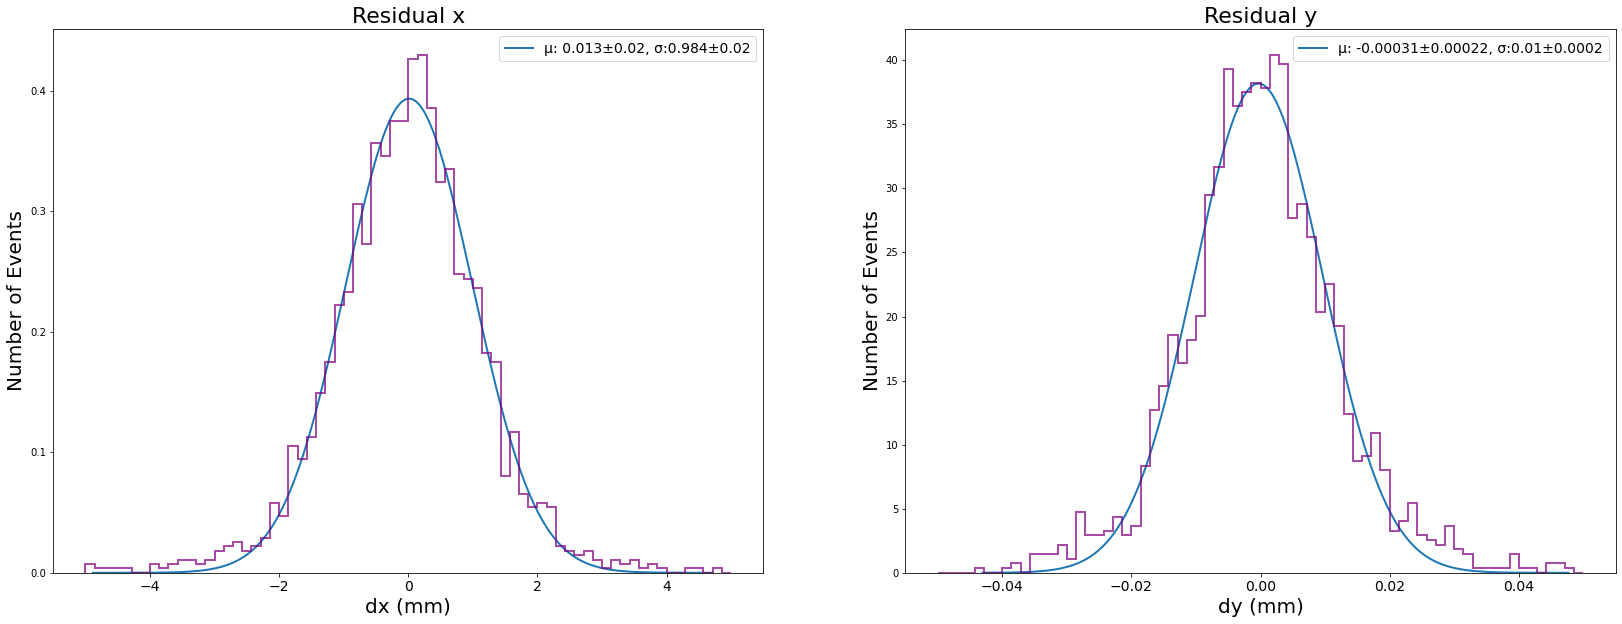

In [169]:
plt.figure(figsize=(28, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(-5, 5, 71)
result, x, mean, mean_err, stddev, stddev_err = gauss_fit(resx, -5, 5)
plt.plot(x, result.best_fit, linewidth=2, label=f'µ: {round(mean, 3)}±{round(mean_err, 3)}, σ:{round(stddev, 3)}±{round(stddev_err, 3)}')
#plt.hist(dx_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'minimum chi2 dx µ: {round(np.mean(dx_tmp), 3)}, σ: {round(np.std(dx_tmp), 3)}')
plt.hist(resx, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple')
plt.title('Residual x', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dx (mm)', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
bin = np.linspace(-0.05, 0.05, 71)
result, x, mean, mean_err, stddev, stddev_err = gauss_fit(resy, -0.05, 0.05)
plt.plot(x, result.best_fit, linewidth=2, label=f'µ: {round(mean, 5)}±{round(mean_err, 5)}, σ:{round(stddev, 4)}±{round(stddev_err, 4)}')
# plt.hist(dy_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'minimum chi2 dy µ: {round(np.mean(dy_tmp), 5)}, σ: {round(np.std(dy_tmp), 3)}')
plt.hist(resy, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple')
plt.title('Residual y', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dy (mm)', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

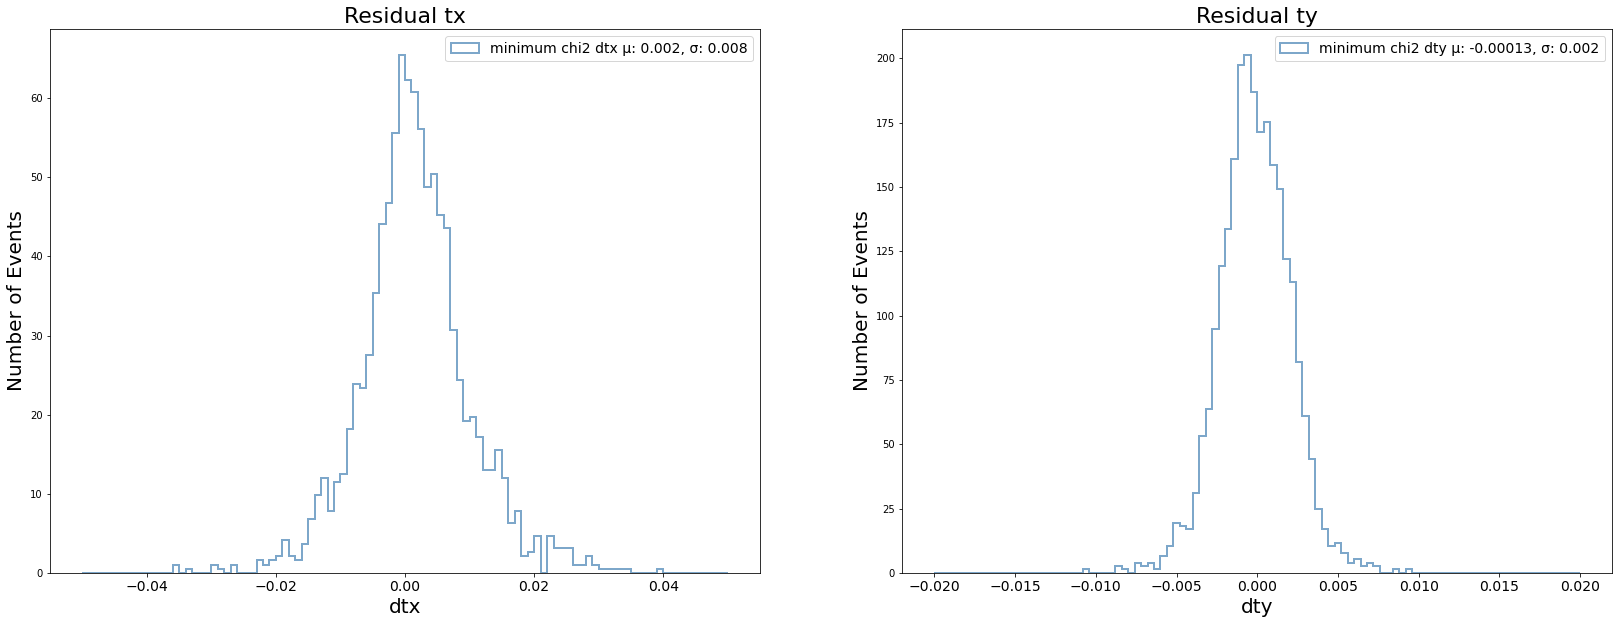

In [167]:
plt.figure(figsize=(28, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(-.05, .05, 101)
plt.hist(dtx_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='steelblue', label=f'minimum chi2 dtx µ: {round(np.mean(dtx_tmp), 3)}, σ: {round(np.std(dtx_tmp), 3)}')
plt.title('Residual tx', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dtx', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
bin = np.linspace(-.02, .02, 101)
plt.hist(dty_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='steelblue', label=f'minimum chi2 dty µ: {round(np.mean(dty_tmp), 5)}, σ: {round(np.std(dty_tmp), 3)}')
plt.title('Residual ty', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dty', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()